In [1]:
%matplotlib inline
import csv
from collections import OrderedDict as odict

import numpy as np
from scipy.stats import linregress,binom,norm,pearsonr
from scipy.optimize import fmin,fmin_tnc,fmin_l_bfgs_b
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.decomposition import NMF,PCA

import stan
import trillion

In [2]:
components = trillion.load_components()
odorants,tests,results = trillion.load_odorants_tests_results(components)

In [3]:
model = stan.StanModel2(model_code=stan.code)

In [114]:
with open('trillion.stan') as f:
    code = f.read()
    model.set_model(code)

In [115]:
data = stan.make_data()
data['n_dimensions'] = 10
data['norm'] = 2

In [116]:
fit = model.model.optimizing(data=data,seed=0,as_vector=False)
lp = fit['value']
fit = fit['par']
#fit

In [122]:
fit

OrderedDict([('kd',
              array([ 1.01585371,  0.4250379 ,  0.30099278,  0.33457804,  0.36443587,
                      0.34960105,  0.31871147,  0.38777162,  0.24523262,  0.27714548,
                      0.25022761,  0.23990742,  0.24904689,  0.21492602,  0.22856643,
                      0.22292931,  0.24095902,  0.19532423,  0.18645763,  0.18888331,
                      0.195139  ,  0.18506964,  0.14163847,  0.1559198 ,  0.10998113,
                      0.08344182])),
             ('exponent',
              array([ 1.4854866 ,  1.48219076,  1.50968989,  1.51827107,  1.40315721,
                      1.45052455,  1.39399729,  1.40191247,  1.58479823,  1.4561053 ,
                      1.45592018,  1.50942482,  1.44287204,  1.49444228,  1.47793343,
                      1.46614737,  1.42759454,  1.49235713,  1.41533383,  1.43596965,
                      1.38185527,  1.39425119,  1.58036169,  1.41491906,  1.56431071,
                      1.42185065])),
             ('molec

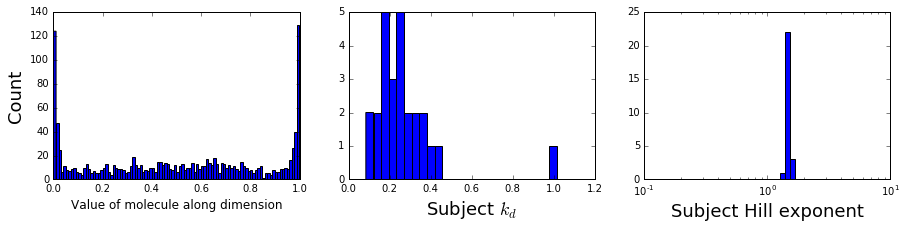

In [119]:
fig,ax = plt.subplots(1,3,figsize=(15,3))
ax[0].hist(fit['molecule_coords'].ravel(),bins=100);
ax[0].set_xlabel('Value of molecule along dimension',size=12)
ax[0].set_ylabel('Count',size=18)
ax[1].hist(fit['kd'],bins=25)
ax[1].set_xlabel('Subject $k_d$',size=18)
ax[2].hist(fit['exponent'],bins=np.logspace(-1, 1, 50));
ax[2].set_xscale('log')
ax[2].set_xlabel('Subject Hill exponent',size=18);

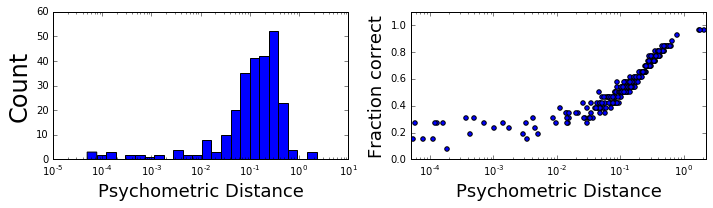

In [128]:
p_correct = np.zeros(data['n_tests'])
for result in results:
    p_correct[result.test.id-1] += result.correct
p_correct /= data['n_subjects']
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(fit['D'],bins=np.logspace(np.log10(fit['D'].min()/1.1),np.log10(fit['D'].max()*1.1),25))
ax[0].set_xscale('log')
ax[0].set_xlabel('Psychometric Distance',size=18)
ax[0].set_ylabel('Count',size=24)
ax[1].scatter(fit['D'],p_correct)
ax[1].set_xscale('log')
ax[1].set_xlim(fit['D'].min()/1.1,fit['D'].max()*1.1)
ax[1].set_ylim(0,1.1)
ax[1].set_xlabel('Psychometric Distance',size=18)
ax[1].set_ylabel('Fraction correct',size=18)
plt.tight_layout()

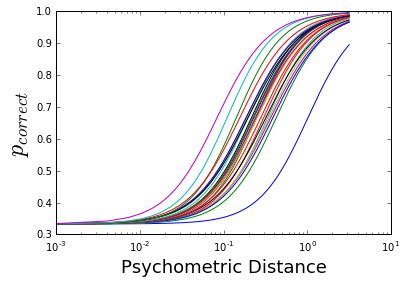

In [129]:
for i in range(26):
    x = np.linspace(0.001,np.sqrt(data['n_dimensions']),1000)
    y = 0.333 + 0.666/(1+(fit['kd'][i]/x)**fit['exponent'][i]);
    plt.plot(x,y)
plt.xscale('log')
plt.xlabel('Psychometric Distance',size=18)
plt.ylabel('$p_{correct}$',size=24);

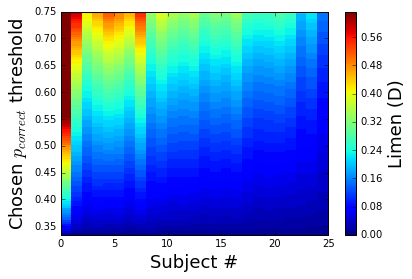

In [132]:
thresholds = np.linspace(0.334,0.75,100)
limens = np.zeros((len(thresholds),26))
for i in range(26):
    x = np.linspace(0.001,100,10000)
    y = 0.333 + 0.666/(1+(fit['kd'][i]/x)**fit['exponent'][i]);
    for j,threshold in enumerate(thresholds):
        limens[j,i] = x[list(y>threshold).index(1)]
plt.pcolor(np.arange(26),thresholds,limens,vmin=0,vmax=np.sqrt(data['n_dimensions'])/5)
plt.xlabel('Subject #',size=18)
plt.ylabel('Chosen $p_{correct}$ threshold',size=18)
plt.ylim(thresholds.min(),thresholds.max())
ax = plt.colorbar()
ax.set_label('Limen (D)',size=18)

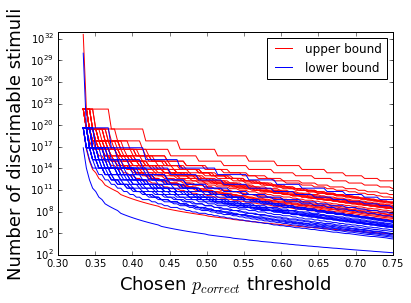

In [133]:
from scipy.special import gamma
N = data['n_dimensions']
for subject in range(26):
    Z_max = np.zeros(len(thresholds))
    Z_min = np.zeros(len(thresholds))
    for j,threshold in enumerate(thresholds):
        D = limens[j,subject]
        total_volume = (1+D)**N
        ball_volume = (np.pi**(N/2))*((D/2)**N)/gamma(N/2 + 1)
        n_balls = total_volume/ball_volume
        Z_max[j] = n_balls
        cube_volume = D**N
        n_balls = total_volume/cube_volume
        Z_min[j] = n_balls
    if subject==0:
        plt.plot(thresholds,Z_max,color='r',label='upper bound')
        plt.plot(thresholds,Z_min,color='b',label='lower bound')
    else:
        plt.plot(thresholds,Z_max,color='r')
        plt.plot(thresholds,Z_min,color='b')
plt.yscale('log')
plt.xlabel('Chosen $p_{correct}$ threshold',size=18)
plt.ylabel('Number of discrimable stimuli',size=18)
plt.legend();

In [5]:
from scipy.stats import bernoulli
def get_logp():
    logp = 0
    for result in results:
        t = result.test.id - 1
        s = result.subject_id - 1
        p_correct = 0.333 + (1-fit['p_dumb'][s])*0.667/(1+(fit['kd'][s]/fit['D'][t])**fit['exponent'][s]);
        logp += np.log(bernoulli.pmf(result.correct,p_correct))
    return logp

In [134]:
dims = [2,3,4,6,8,10,12,15,18,21,24,28,32,36,40]
n_seeds = 3
logp = np.zeros((len(dims),2,n_seeds))
for i,dim in enumerate(dims):
    for norm in [1,2]:
        print(dim,norm)
        data['n_dimensions'] = dim
        data['norm'] = norm
        for seed in range(n_seeds):
            fit = model.model.optimizing(data=data,seed=seed,as_vector=False)
            logp[i,norm-1,seed] = fit['value']

2 1
2 2
3 1
3 2
4 1
4 2
6 1
6 2
8 1
8 2
10 1
10 2
12 1
12 2
15 1
15 2
18 1
18 2
21 1
21 2
24 1
24 2
28 1
28 2
32 1
32 2
36 1
36 2
40 1
40 2


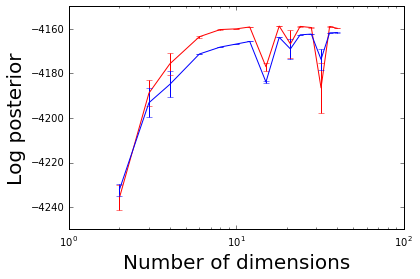

In [135]:
plt.errorbar(dims,logp[:,0,:].mean(axis=1),logp[:,0,:].std(axis=1)/np.sqrt(n_seeds),color='red')
plt.errorbar(dims,logp[:,1,:].mean(axis=1),logp[:,1,:].std(axis=1)/np.sqrt(n_seeds),color='blue')
plt.xlabel('Number of dimensions',size=20)
plt.ylabel('Log posterior',size=20)
plt.xscale('log')

In [251]:
sampling = model.model.sampling(data=data,seed=0)

KeyboardInterrupt: 

## Old stuff

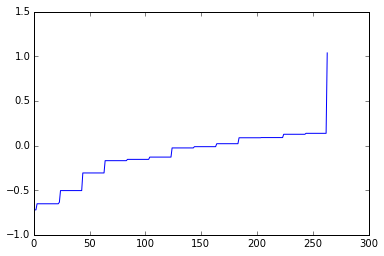

In [302]:
plt.plot(sorted(fit['r_difficulty']))

In [298]:
classes

[(30, 30),
 (10, 4),
 (10, 1),
 (10, 10),
 (30, 10),
 (30, 1),
 (20, 5),
 (20, 15),
 (20, 20),
 (30, 20),
 (10, 7),
 (20, 10),
 (20, 1),
 (10, 8),
 (1, 1)]

In [304]:
fit['r_skill']

array([ 1.9971231 ,  1.89579127,  0.58830606, -0.66819226, -1.85233421,
       -1.35333001,  0.65730394, -1.66146483, -1.18367949, -1.3309337 ,
        0.61868429, -1.4847911 ,  1.63869907, -1.55311848, -0.80424805,
       -0.93843393,  0.79829339,  1.79962717, -1.63267216,  1.60791963,
        1.83715119,  1.65851249, -0.23560068, -1.70566037,  1.69658172,
       -1.64685   ])

(30, 30) 4.0275 5.358325
(10, 4) 9.4875 5.33106
(10, 1) 15.8875 5.390495
(10, 10) 21.7475 5.256985
(30, 10) 18.1875 5.4422625
(30, 1) 6.55 5.36307
(20, 5) 10.0275 5.2875275
(20, 15) 11.0475 5.491615
(20, 20) 11.15 5.30324
(30, 20) 16.6275 5.373455
(10, 7) 20.0332409972 5.36486980609
(20, 10) 11.01 5.4259675
(20, 1) 12.11 5.4351825


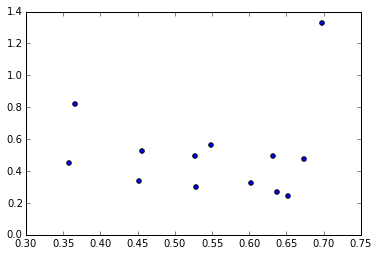

In [303]:
actual_vars = []
expected_vars = []
actual_means = []
for i,class_ in enumerate(classes):
    N,r = class_
    if N == 1 or r == 8:
        continue
    fraction_correct = trillion.fraction_disc(results,N,N-r,fig='b')
    actual_means.append(fraction_correct.mean())
    actual_var = (fraction_correct*26).var()
    test_indices = (np.where(data['class_']==(i+1))[0])
    ps = np.zeros((len(test_indices),data['n_subjects']))
    for j,test_index in enumerate(test_indices):
        difficulty = fit['r_difficulty'][test_index]
        steep = fit['r_steep'][test_index]
        for subject in range(data['n_subjects']):
            skill = fit['r_skill'][subject]
            ps[j][subject] = 0.333 + 0.667/(1+np.exp(-steep*(skill-difficulty)))
    expected_var = np.mean([binom.rvs(1,ps).sum(axis=1).var() for _ in range(1000)])
    expected_vars.append(expected_var)
    actual_vars.append(actual_var)
    print(class_,actual_var,expected_var)
plt.scatter(actual_means,np.array(expected_vars)/np.array(actual_vars))

In [6]:
masks = []
for i in range(100):
    masks.append(binom.rvs(1,0.25,size=data['n_obs']))

In [8]:
def compute_ll(x):
    ll = 0
    for i in np.where(data['mask']==1)[0]:
        test_id = data['test_ids'][i]
        subject_id = data['subject_ids'][i]
        p = 0.333 + 0.667/(1+np.exp(-x['r_steep'][test_id-1]*(x['r_skill'][subject_id-1]-x['r_difficulty'][test_id-1])))
        #print(p)
        p = min(1.0,p)
        ll += binom.logpmf(data['correct'][i],1,p)
    return ll

In [9]:
iters = 10
vals = np.logspace(-2,1,9)
while True:
    for sigma in ['sigma_skill','sigma_difficulty','sigma_steep']:
        lls = []
        for val in vals:
            data[sigma] = val
            lls2 = []    
            for i in range(iters):
                data['mask'] = masks[i]
                x = model2.model.optimizing(data=data,seed=i)
                lls2.append(compute_ll(x))
            lls.append(np.median(lls2))
        from scipy import interpolate
        f_interp = interpolate.interp1d(vals, lls)
        vals_new = np.logspace(-2,1,99)
        lls_new = f_interp(vals_new)   # use interpolation function returned by `interp1d`
        vals_max = vals_new[lls_new.argmax()]
        print(sigma,vals,lls,vals_max)
        data[sigma] = vals_max

[  0.01         0.02371374   0.05623413   0.13335214   0.31622777
   0.74989421   1.77827941   4.21696503  10.        ] [-1122.3008637779924, -1129.1995183681906, -1129.8115345886022, -1115.0204550772792, -1114.2753778839992, -1115.5158929484123, -1126.7309232443774, -1127.4265508320173, -1125.3709189497681] 0.316227766017
[  0.01         0.02371374   0.05623413   0.13335214   0.31622777
   0.74989421   1.77827941   4.21696503  10.        ] [-1221.7558353083389, -1197.0866855415161, -1181.1703909861553, -1144.8692084046115, -1122.1059038995093, -1117.6454494890895, -1118.416826634359, -1129.715732504329, -1135.6043999882368] 0.790604321091
[  0.01         0.02371374   0.05623413   0.13335214   0.31622777
   0.74989421   1.77827941   4.21696503  10.        ] [-1232.2311191472445, -1217.3339216138033, -1175.8237684772866, -1144.7210570584684, -1111.9159859965407, -1112.2632381349033, -1120.5255800767623, -1128.645766507158, -1144.7821517286266] 0.316227766017
[  0.01         0.02371374  

KeyboardInterrupt: 

In [10]:
data

{'class_': array([ 1,  2,  3,  4,  5,  6,  7,  5,  6,  8,  3,  2,  4,  8,  9,  8,  7,
        10,  5,  5,  2,  8,  2,  5,  7, 11,  1, 12, 11, 13, 13, 13, 10,  3,
         7,  4,  4,  6,  8,  7,  4, 10,  9,  9,  6, 13, 12,  1,  8,  4,  5,
        11,  3,  5,  4,  7,  4,  6,  3, 11, 13, 13, 13, 11,  2,  9, 13,  3,
         2, 10, 11,  2, 11,  1,  8, 12,  9,  1, 12, 14,  7,  3, 12,  9,  4,
         6,  3,  3,  6,  3,  1, 11, 10, 10, 10,  1,  4, 10,  2, 15, 13,  6,
         8,  6,  8,  9,  7, 10, 12, 12,  5,  9, 10,  6,  8, 10, 12, 11,  6,
         4,  5,  1,  8,  2,  9, 13,  2,  1,  4, 10, 11,  6, 13,  6, 12,  3,
         1, 11,  2,  5,  6,  4,  7,  5, 13,  1,  9, 15,  1,  2,  8,  1,  7,
        12,  1,  4,  5,  2, 12,  9,  4,  7,  8, 11, 13,  3, 13,  7,  1, 12,
         8,  3,  6, 13,  8, 10,  9,  3, 13,  6, 12, 15, 13, 10,  8,  5,  2,
         1,  3, 11,  2, 12,  5,  3,  7,  2,  9,  9,  6,  8,  8, 11,  1,  1,
         4,  7,  2,  4,  3,  7, 11,  2, 12, 11,  3,  9, 13,  6,  9,  3,  5,
  

In [74]:
data['mask'] = np.zeros(data['n_obs']).astype(int)
fit = model2.model.optimizing(data=data,seed=0)

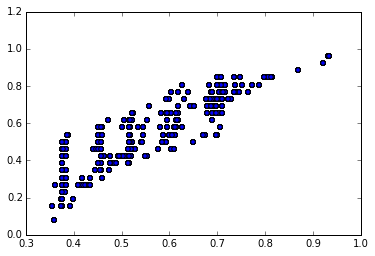

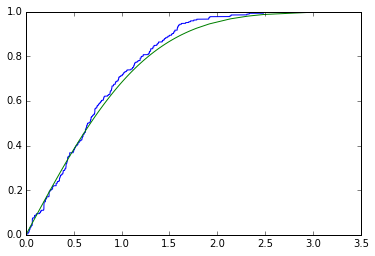

In [18]:
def plot():
    predicted = []
    observed = []
    for class_ in range(1,data['n_classes']+1):
        for test_id in range(1,data['n_tests']+1):
            obs = np.mean(data['correct'][np.where(data['test_ids']==test_id)])
            observed.append(obs)
            pred = 0
            for subject_id in range(data['n_subjects']):
                pred += 0.333 + 0.667/(1+np.exp(-x['r_steep'][test_id-1]*(x['r_skill'][subject_id]-x['r_difficulty'][test_id-1])))
            pred /= data['n_subjects']
            predicted.append(pred)
    predicted = np.array(predicted)
    observed = np.array(observed)
    plt.scatter(predicted,observed)
    plt.figure()
    z = abs(observed-predicted) / (np.sqrt(predicted*(1-predicted))/np.sqrt(26))
    plt.plot(sorted(z),np.linspace(0,1,len(z)))
    plt.plot(sorted(z),1-2*(1-norm.cdf(sorted(z))))
    
plot()

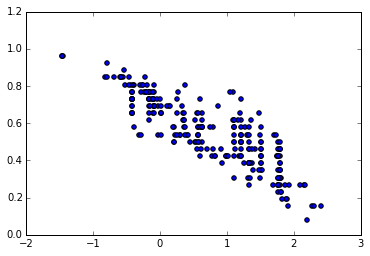

In [75]:
frac_correct = [test.fraction_correct(results) for test in tests.values()]
plt.scatter(fit['r_difficulty'],frac_correct)

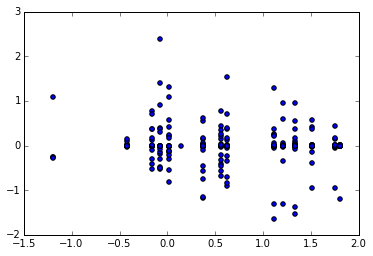

In [76]:
class_difficulty = np.array([fit['class_difficulty'][class_-1] for class_ in data['class_']])
plt.scatter(class_difficulty,fit['r_difficulty']-class_difficulty)

In [69]:
CIDs_snitz = {} # To store Snitz et al. descriptors.  
CIDs_all = {} # To store all descriptors.  

# The 21 molecular descriptors "discovered" in Snitz et al.  
snitz_descriptors = ['nCIR','ZM1','GNar','S1K','piPC08','MATS1v','MATS7v',]
snitz_descriptors += ['GATS1v','EEig05x','ESpm02x','ESpm03d','ESpm10d','ESpm13d','BELv3']
snitz_descriptors += ['RDF035v','G1m','G1v','G1e','G3s','R8u+','nRCOSR']

# Create dictionaries of descriptor values for molecules in Snitz using their supplemental table.  
# Their supplemental table has >1000 descriptors for each molecule, which is a good fraction of what is in Dragon.  
with open('../qol/data/snitz_tableS1.csv') as f:
    reader = csv.reader(f)
    descriptors = reader.__next__()[1:]
    for line in reader:
        CID = int(float(line[0]))
        values = [float(_) for i,_ in enumerate(line[1:]) if descriptors[i] in snitz_descriptors]
        CIDs_snitz[CID] = odict(zip(snitz_descriptors,values))
        values_all = [float(_) for i,_ in enumerate(line[1:])]
        CIDs_all[CID] = odict(zip(descriptors,values_all))

In [64]:
angles = np.array([test.angle(CIDs_snitz) if test.N > 1 else np.NaN for test in tests.values()])

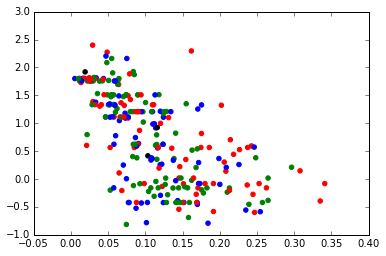

In [77]:
test_colors = [{1:'k', 10:'r',20:'g',30:'b'}[test.N] for test in tests.values()]
plt.scatter(angles,fit['r_difficulty'],color=test_colors)

In [78]:
# The descriptors in the Snitz supplemental table are already normalized to 0.0 (min value across molecules) to 1.0 (max).  
# Make a matrix of CIDs by descriptor values.  
x = np.array([[CIDs_all[CID][descriptor] for descriptor in descriptors] for CID in CIDs_all.keys()])
#x = scale(x) # Scale to mean=0, variance=1.  
CIDs_all_normed,CIDs_normed = {},{}
for i,CID in enumerate(CIDs_all):
    CIDs_all_normed[CID] = {}
    CIDs_normed[CID] = {}
    for j,descriptor in enumerate(descriptors):
        CIDs_all_normed[CID][descriptor] = x[i,j]
        if descriptor in snitz_descriptors:
            CIDs_normed[CID][descriptor] = x[i,j]

In [81]:
# Non-negative matrix factorization of the x matrix.  
nmf_200 = NMF(n_components=200, nls_max_iter=500) # 200 determined to be reasonable in a separate analysis.  
nmf_200.fit(x) # Fit the x matrix to this NMF basis.  

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/decomposition/nmf.py:252: UserWarning: Iteration limit reached in nls subproblem.
  warnings.warn("Iteration limit reached in nls subproblem.")
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/decomposition/nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


NMF(beta=1, eta=0.1, init=None, max_iter=200, n_components=200,
  nls_max_iter=500, random_state=None, sparseness=None, tol=0.0001)

In [82]:
print("Total reconstruction error using %d components is %.2f" % (nmf_200.components_.shape[1],nmf_200.reconstruction_err_))
x_nmf_200 = nmf_200.transform(x) # Transformation of x using this NMF basis.  
print("Transformed matrix has %d molecules and %d descriptor dimensions" % (x_nmf_200.shape[0],x_nmf_200.shape[1]))

Total reconstruction error using 1433 components is 28.60
Transformed matrix has 1318 molecules and 200 descriptor dimensions


In [83]:
# Create a new ordered dictionary from the NMF transformation.  
CIDs_nmf_200 = {}
for i,CID in enumerate(CIDs_all):
    CIDs_nmf_200[CID] = odict()
    for j in range(x_nmf_200.shape[1]):
        CIDs_nmf_200[CID][j] = x_nmf_200[i,j]

In [91]:
angles = np.array([test.angle(CIDs_nmf_200) if test.N > 1 else 0.6 for test in tests.values()])

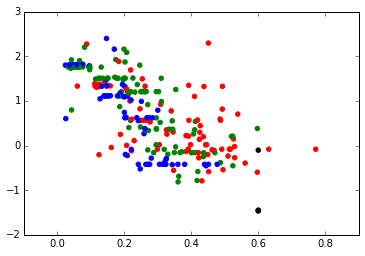

In [92]:
test_colors = [{1:'k', 10:'r',20:'g',30:'b'}[test.N] for test in tests.values()]
plt.scatter(angles,fit['r_difficulty'],color=test_colors)

In [93]:
print(pearsonr(angles,fit['r_difficulty']))

(-0.73575314795514568, 3.0232192224931624e-46)


In [94]:
0.735**2

0.540225

In [101]:
for order in np.logspace(-1,1,25):
    mask = np.zeros(len(tests))
    for i,test in enumerate(tests.values()):
        if test.N == 1:
            mask[i] = 1
    norms = np.ma.array([test.norm(CIDs_nmf_200,order=order) if test.N > 1 else np.NaN for test in tests.values()],mask=mask)
    print(order,np.ma.corrcoef(norms,fit['r_difficulty'])[0,1])

0.1 -0.633766234308
0.121152765863 -0.639254424856
0.146779926762 -0.64498303677
0.177827941004 -0.650802951769
0.215443469003 -0.656535841915
0.261015721568 -0.661987673294
0.316227766017 -0.666964835118
0.383118684956 -0.671286625353
0.464158883361 -0.674785543587
0.56234132519 -0.677285480768
0.681292069058 -0.678544628892
0.825404185268 -0.678137117365
1.0 -0.67521302553
1.21152765863 -0.668022096949
1.46779926762 -0.653129515866
1.77827941004 -0.624881899079
2.15443469003 -0.577305242246
2.61015721568 -0.509990669674
3.16227766017 -0.431960997805
3.83118684956 -0.356480546429
4.64158883361 -0.293099578814
5.6234132519 -0.244799100918
6.81292069058 -0.209558597775
8.25404185268 -0.183253266486
10.0 -0.162097258622


In [102]:
print(np.ma.corrcoef(angles,fit['r_difficulty'])[0,1])

-0.735753147955


In [138]:
tests_N = {}
difficulty = {}
for N in [10,20,30]:
    tests_N[N] = []
    difficulty[N] = []
    for test_id,test in tests.items():
        if test.N == N:
            tests_N[N].append(test)
            difficulty[N].append(fit['r_difficulty'][test_id-1])

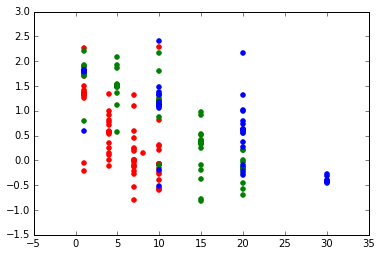

In [139]:
for N in [10,20,30]:
    plt.scatter([test.r for test in tests_N[N]],difficulty[N],color={1:'k', 10:'r',20:'g',30:'b'}[N])

In [232]:
def get_r2(prediction,observed):
    """Compute the coefficient of determination R^2 from the data"""
    prediction = np.array(prediction)
    observed = np.array(observed)
    ss_error = np.sum((observed-prediction)**2)
    ss_total = np.sum((observed-observed.mean())**2)
    return 1 - ss_error/ss_total

def f(weights,descriptors,alpha,tests_N,difficulty):
    angles = {}
    for N in [10,20,30]:
        angles[N] = []
        for test in tests_N[N]:
            angles[N].append(test.angle(descriptors,weights=weights,method='sum')/test.N)
    r2s = []
    sses = []
    for N in 10,20,30:
        angles[N] = np.array(angles[N])
        x = angles[N]
        y = difficulty[N]
        slope, intercept, _, _, _ = linregress(x,y)
        prediction = np.array([intercept + slope*angle for angle in angles[N]])
        r2 = get_r2(prediction,difficulty[N])
        sse = np.mean((prediction-difficulty[N])**2)
        r2s.append(r2)
        sses.append(sse)
    obj = -np.mean(r2s) + alpha*np.abs(weights).sum()
    if np.random.randint(25) == 0:
        print('%.3g' % obj)#,len(np.where(np.abs(weights)>0.1)[0]),r2s)
    return obj

In [233]:
#fitted_weights = np.ones(200)
fitted_weights = fmin_l_bfgs_b(f,fitted_weights,fprime=None,args=(CIDs_nmf_200,1e-4,tests_N,difficulty),approx_grad=True,maxiter=1e6)[0]

-0.654
-0.654
-0.66
-0.66
-0.66
-0.66
-0.66
-0.66
-0.66
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.662
-0.675
-0.675
-0.675
-0.675
-0.675
-0.681
-0.681
-0.681
-0.681
-0.681
-0.681
-0.681
-0.681
-0.681
-0.682
-0.682
-0.682
-0.682
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.684
-0.685
-0.685
-0.685
-0.685
-0.685
-0.685
-0.685
-0.686
-0.686
-0.686
-0.686
-0.686
-0.686
-0.686
-0.686
-0.686
-0.689
-0.689
-0.691
-0.691
-0.691
-0.691
-0.691
-0.691
-0.693
-0.693
-0.693
-0.693
-0.693
-0.694
-0.694
-0.694
-0.694
-0.695
-0.695
-0.695
-0.695
-0.695
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.696
-0.697
-0.697
-0.697
-0.697
-0.697
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698
-0.698

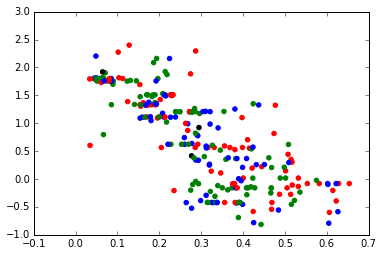

In [234]:
test_colors = [{1:'k', 10:'r',20:'g',30:'b'}[test.N] for test in tests.values()]
angles = np.array([test.angle(CIDs_nmf_200,weights=fitted_weights) if test.N > 1 else np.nan for test in tests.values()])
plt.scatter(angles,fit['r_difficulty'],color=test_colors)

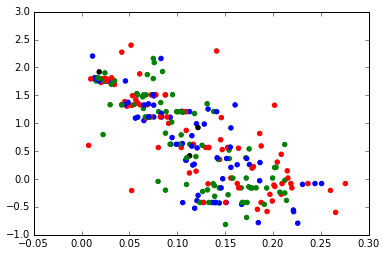

In [236]:
norms = np.array([test.norm(CIDs_nmf_200,weights=fitted_weights,order=1.0)/test.N if test.N > 1 else np.nan for test in tests.values()])
plt.scatter(norms,fit['r_difficulty'],color=test_colors)

In [225]:
def length(v):
    return np.sqrt(np.dot(v, v))
    
def find_angle(v1,v2):
    return np.arccos(np.dot(v1, v2) / (length(v1) * length(v2)))

x_weighted = x_nmf_200 * fitted_weights[np.newaxis,:]
for N in [10,20,30]:
    angles = []
    for i in range(2500):
        indices = np.random.choice(np.arange(1318),N)
        v1 = x_weighted[indices,:].sum(axis=0)
        indices = np.random.choice(np.arange(1318),N)
        v2 = x_weighted[indices,:].sum(axis=0)
        angles.append(find_angle(v1,v2))
    print(N,np.mean(angles))

10 0.61099695922
20 0.451946062249
30 0.376242498329


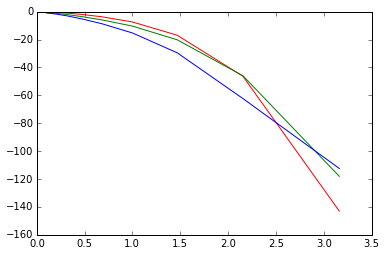

In [203]:
orders = np.logspace(-1,0.5,10)
for N in [10,20,30]:
    slopes = []
    for order in orders:
        x = [test.norm(CIDs_nmf_200,weights=fitted_weights,order=order)/test.N for test in tests_N[N]]
        y = difficulty[N]
        slope, intercept, _, _, _ = linregress(x,y)
        slopes.append(slope)
    plt.plot(orders,slopes,color={1:'k', 10:'r',20:'g',30:'b'}[N])

In [237]:
for N in [10,20,30]:
    r = np.ma.corrcoef([test.angle(CIDs_snitz) for test in tests_N[N]],difficulty[N])[0,1]
    print(N,r**2)

for N in [10,20,30]:
    r = np.ma.corrcoef([test.angle(CIDs_nmf_200) for test in tests_N[N]],difficulty[N])[0,1]
    print(N,r**2)

print(np.ma.corrcoef(angles,fit['r_difficulty'])[0,1]**2)
for N in [10,20,30]:
    r = np.ma.corrcoef([test.angle(CIDs_nmf_200,weights=fitted_weights) for test in tests_N[N]],difficulty[N])[0,1]
    print(N,r**2)

10 0.318356714385
20 0.521586930389
30 0.644954873592
10 0.323825451336
20 0.658979819879
30 0.732501637653
0.642741696329
10 0.603878688029
20 0.713134884365
30 0.801182837426


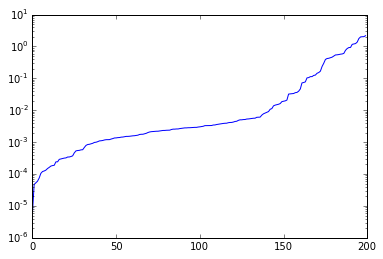

In [166]:
plt.plot(sorted(np.abs(fitted_weights)))
plt.yscale('log')